In [1]:
import json
import torch
import pdb
import pyarrow.feather as feather
from typing import List, Tuple, Any, Dict
from PIL import Image
import numpy as np
import pandas as pd
import pickle

from pathlib import Path
from av2.datasets.sensor.av2_sensor_dataloader import AV2SensorDataLoader
from av2.datasets.sensor.sensor_dataloader import SensorDataloader
from av2.datasets.sensor.constants import RingCameras, AnnotationCategories
from av2.geometry.camera.pinhole_camera import PinholeCamera
from av2.map.map_api import ArgoverseStaticMap, DrivableAreaMapLayer
from av2.geometry.se3 import SE3
from av2.geometry.geometry import compute_interior_points_mask
from av2.rendering.rasterize import xyz_to_bev
from av2.structures.cuboid import CuboidList
from av2.utils.io import read_city_SE3_ego, read_img
import random


STATIC = [
    AnnotationCategories.BOLLARD ,
    AnnotationCategories.CONSTRUCTION_BARREL ,
    AnnotationCategories.CONSTRUCTION_CONE ,
    AnnotationCategories.MOBILE_PEDESTRIAN_CROSSING_SIGN ,
    AnnotationCategories.SIGN ,
    AnnotationCategories.STOP_SIGN ,
    AnnotationCategories.TRAFFIC_LIGHT_TRAILER ,
    AnnotationCategories.MOBILE_PEDESTRIAN_CROSSING_SIGN ,

          ]
DYNAMIC = [
    AnnotationCategories.ARTICULATED_BUS ,
    AnnotationCategories.BICYCLE ,
    AnnotationCategories.ANIMAL ,
    AnnotationCategories.BICYCLIST ,
    AnnotationCategories.BOX_TRUCK ,
    AnnotationCategories.BUS ,
    AnnotationCategories.DOG ,
    AnnotationCategories.LARGE_VEHICLE ,
    AnnotationCategories.MESSAGE_BOARD_TRAILER ,
    AnnotationCategories.MOTORCYCLE ,
    AnnotationCategories.MOTORCYCLIST ,
    AnnotationCategories.OFFICIAL_SIGNALER ,
    AnnotationCategories.PEDESTRIAN ,
    AnnotationCategories.BICYCLIST ,
    AnnotationCategories.RAILED_VEHICLE ,
    AnnotationCategories.REGULAR_VEHICLE ,
    AnnotationCategories.SCHOOL_BUS ,
    AnnotationCategories.STROLLER ,
    AnnotationCategories.TRUCK ,
    AnnotationCategories.TRUCK_CAB ,
    AnnotationCategories.VEHICULAR_TRAILER ,
    AnnotationCategories.WHEELCHAIR ,
    AnnotationCategories.WHEELED_RIDER ,
    AnnotationCategories.WHEELED_DEVICE ,
          ]
NUM_CLASSES = len(STATIC) + len(DYNAMIC)



In [2]:
import os
os.chdir('/coc/pskynet2/apatni30/raster-net/comparison/cross_view_transformers/cross_view_transformer/')
print(os.getcwd())

/coc/pskynet2/apatni30/raster-net/comparison/cross_view_transformers/cross_view_transformer


In [3]:
from cross_view_transformer.data.argoverse2_dataset import Argoverse2Dataset

In [4]:
import pickle
with open('/srv/share2/apatni30/tmp/AV2_dataset.pkl', 'rb') as f:
    data = pickle.load(f)

In [99]:
pose = data.samples[0]['pose']
xpoints = np.arange(-data.bev_info['h_meters']/2,data.bev_info['h_meters']/2,data.bev_info['h_meters']/data.bev_info['h'])
ypoints = np.arange(-data.bev_info['w_meters']/2,data.bev_info['w_meters']/2,data.bev_info['w_meters']/data.bev_info['w'])
zpoints = np.array([i/10.0 for i in range(20)])
points_xy_wrt_src = np.vstack(map(np.ravel, np.meshgrid(xpoints, ypoints, zpoints))).T
points_xy_wrt_city = pose.transform_point_cloud(points_xy_wrt_src) 

/tmp/ipykernel_14197/1674624226.py:5: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  points_xy_wrt_src = np.vstack(map(np.ravel, np.meshgrid(xpoints, ypoints, zpoints))).T


In [154]:
pose = data.samples[0]['pose']
xpoints = np.arange(-10,10,1)
ypoints = np.arange(-10,10,1)
zpoints = np.arange(-1,1, 1)
points_xy_wrt_src = np.vstack(map(np.ravel, np.meshgrid(xpoints, ypoints, zpoints))).T
points_xy_wrt_city = pose.transform_point_cloud(points_xy_wrt_src) 

/tmp/ipykernel_14197/705292459.py:5: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  points_xy_wrt_src = np.vstack(map(np.ravel, np.meshgrid(xpoints, ypoints, zpoints))).T


In [155]:
cmap = np.zeros(shape=(points_xy_wrt_city.shape[0], 3))
drivable_area_raster = data.avm.raster_drivable_area_layer.get_raster_values_at_coords(points_xy_wrt_city, 0)
cmap[drivable_area_raster==0] = (255,0,0)
cmap[drivable_area_raster==1] = (220,220,220)

In [156]:
print(np.unique(drivable_area_raster, return_counts=True))
print(np.unique(cmap,return_counts=True))
points_xy_wrt_city

(array([0, 1]), array([250, 550]))
(array([  0., 220., 255.]), array([ 500, 1650,  250]))


array([[ 130.31639062, 3614.70117522,  -23.06963217],
       [ 130.32291032, 3614.69695104,  -22.06966235],
       [ 130.2817318 , 3615.70056453,  -23.06518447],
       ...,
       [ 110.71087064, 3632.02690973,  -21.86858677],
       [ 110.66969211, 3633.03052321,  -22.8641089 ],
       [ 110.67621181, 3633.02629903,  -21.86413907]])

In [145]:
import pdb

for annotation in CuboidList.from_feather(Path(data.log_specific_dataset_path, 'annotations.feather')):
    if annotation.timestamp_ns == data.samples[0]["token"]:
        annotation = annotation.transform(pose)      
        interior_points, is_interior = annotation.compute_interior_points(points_xy_wrt_city)          
        if annotation.category in STATIC:
            # print("static")
            # print(interior_points)
            # print(annotation.dst_SE3_object.translation)
            # print(annotation.width_m, annotation.length_m, annotation.height_m)
            # print(np.count_nonzero(is_interior))
            cmap[is_interior] = (255,127,80)            
        elif annotation.category in DYNAMIC:
            # print("dynamic")
            # print(interior_points)
            # print(annotation.dst_SE3_object.translation)
            # print(annotation.width_m, annotation.length_m, annotation.height_m)
            # print(np.count_nonzero(is_interior))
            cmap[is_interior] = (30,144,255)

In [160]:
# ==============================================================================
#                                                                   SCALE_TO_255
# ==============================================================================
def scale_to_255(a, min, max, dtype=np.uint8):
    """ Scales an array of values from specified min, max range to 0-255
        Optionally specify the data type of the output (default is uint8)
    """
    return (((a - min) / float(max - min)) * 255).astype(dtype)
# ==============================================================================
#                                                         POINT_CLOUD_2_BIRDSEYE
# ==============================================================================
def point_cloud_2_birdseye(points,
                           cmap=None,
                           res=.5,
                           side_range=(-50., 50.),  # left-most to right-most
                           fwd_range = (-50., 50.), # back-most to forward-most
                           height_range=(-2., 2.),  # bottom-most to upper-most
                           ):
    """ Creates an 2D birds eye view representation of the point cloud data.

    Args:
        points:     (numpy array)
                    N rows of points data
                    Each point should be specified by at least 3 elements x,y,z
        res:        (float)
                    Desired resolution in metres to use. Each output pixel will
                    represent an square region res x res in size.
        side_range: (tuple of two floats)
                    (-left, right) in metres
                    left and right limits of rectangle to look at.
        fwd_range:  (tuple of two floats)
                    (-behind, front) in metres
                    back and front limits of rectangle to look at.
        height_range: (tuple of two floats)
                    (min, max) heights (in metres) relative to the origin.
                    All height values will be clipped to this min and max value,
                    such that anything below min will be truncated to min, and
                    the same for values above max.
    Returns:
        2D numpy array representing an image of the birds eye view.
    """
    # EXTRACT THE POINTS FOR EACH AXIS
    x_points = points[:, 0].astype(np.float32)
    y_points = points[:, 1].astype(np.float32)
    z_points = points[:, 2].astype(np.float32)
    y_translation = float(side_range[1] / 2)
    x_translation = float(fwd_range[0] / 2)
    x_points += x_translation
    y_points += y_translation
    print(x_points)
    print(y_points)
    # # FILTER - To return only indices of points within desired cube
    # # Three filters for: Front-to-back, side-to-side, and height ranges
    # # Note left side is positive y axis in LIDAR coordinates
    # # f_filt = np.logical_and((x_points > fwd_range[0]), (x_points < fwd_range[1]))
    # # s_filt = np.logical_and((y_points > -side_range[1]), (y_points < -side_range[0]))
    # # filter = np.logical_and(f_filt, s_filt)
    # # indices = np.argwhere(filter).flatten()

    # # KEEPERS
    # x_points = x_points[indices]
    # y_points = y_points[indices]
    # z_points = z_points[indices]

    # CONVERT TO PIXEL POSITION VALUES - Based on resolution
    x_img = (-y_points / res).astype(np.int32)  # x axis is -y in LIDAR
    y_img = (-x_points / res).astype(np.int32)  # y axis is -x in LIDAR

    # SHIFT PIXELS TO HAVE MINIMUM BE (0,0)
    # floor & ceil used to prevent anything being rounded to below 0 after shift
    # x_img -= int(np.floor(side_range[0] / res))
    # y_img += int(np.ceil(fwd_range[1] / res))

    print(x_img.shape)
    print(y_img.shape)
    print(cmap.shape)

    # CLIP HEIGHT VALUES - to between min and max heights
    # pixel_values = np.clip(a=z_points,
    #                        a_min=height_range[0],
    #                        a_max=height_range[1])

    # # RESCALE THE HEIGHT VALUES - to be between the range 0-255
    # pixel_values = scale_to_255(pixel_values,
    #                             min=height_range[0],
    #                             max=height_range[1])

    pixel_values = cmap

    # INITIALIZE EMPTY ARRAY - of the dimensions we want
    x_max = 1 + int((side_range[1] - side_range[0]) / res)
    y_max = 1 + int((fwd_range[1] - fwd_range[0]) / res)
    im = np.zeros([y_max, x_max, 3], dtype=np.uint8)

    # FILL PIXEL VALUES IN IMAGE ARRAY
    im[y_img, x_img, :] = pixel_values

    return im

In [161]:
a = point_cloud_2_birdseye(points_xy_wrt_src, cmap)
a.shape
# import cv2
# bgr_image = cv2.cvtColor(a, cv2.COLOR_RGB2BGR)
# cv2.imwrite("/srv/share2/apatni30/tmp/bev.png",bgr_image)

[-35. -35. -34. -34. -33. -33. -32. -32. -31. -31. -30. -30. -29. -29.
 -28. -28. -27. -27. -26. -26. -25. -25. -24. -24. -23. -23. -22. -22.
 -21. -21. -20. -20. -19. -19. -18. -18. -17. -17. -16. -16. -35. -35.
 -34. -34. -33. -33. -32. -32. -31. -31. -30. -30. -29. -29. -28. -28.
 -27. -27. -26. -26. -25. -25. -24. -24. -23. -23. -22. -22. -21. -21.
 -20. -20. -19. -19. -18. -18. -17. -17. -16. -16. -35. -35. -34. -34.
 -33. -33. -32. -32. -31. -31. -30. -30. -29. -29. -28. -28. -27. -27.
 -26. -26. -25. -25. -24. -24. -23. -23. -22. -22. -21. -21. -20. -20.
 -19. -19. -18. -18. -17. -17. -16. -16. -35. -35. -34. -34. -33. -33.
 -32. -32. -31. -31. -30. -30. -29. -29. -28. -28. -27. -27. -26. -26.
 -25. -25. -24. -24. -23. -23. -22. -22. -21. -21. -20. -20. -19. -19.
 -18. -18. -17. -17. -16. -16. -35. -35. -34. -34. -33. -33. -32. -32.
 -31. -31. -30. -30. -29. -29. -28. -28. -27. -27. -26. -26. -25. -25.
 -24. -24. -23. -23. -22. -22. -21. -21. -20. -20. -19. -19. -18. -18.
 -17. 

(201, 201, 3)

In [153]:
points_xy_wrt_src

array([[-50. , -50. ,   0. ],
       [-50. , -50. ,   0.1],
       [-50. , -50. ,   0.2],
       ...,
       [ 49.5,  49.5,   1.7],
       [ 49.5,  49.5,   1.8],
       [ 49.5,  49.5,   1.9]])

In [149]:
data.samples[0]

{'scene': '85026edc-5fdf-308e-a8ef-a1aad1151c50',
 'token': 315969704859956000,
 'pose': SE3(rotation=array([[-0.03465883, -0.99937794,  0.0065197 ],
        [ 0.99938931, -0.03468678, -0.00422418],
        [ 0.0044477 ,  0.00636931,  0.99996982]]), translation=array([ 119.98254269, 3624.3439763 ,  -21.9614922 ])),
 'cam_ids': range(0, 7),
 'cam_channels': ['ring_rear_left',
  'ring_side_left',
  'ring_front_left',
  'ring_front_center',
  'ring_front_right',
  'ring_side_right',
  'ring_rear_right'],
 'intrinsics': {'ring_rear_left': Intrinsics(fx_px=1683.679818863081, fy_px=1683.679818863081, cx_px=1026.1526389231901, cy_px=771.4666541420552, width_px=2048, height_px=1550),
  'ring_side_left': Intrinsics(fx_px=1682.2951073529744, fy_px=1682.2951073529744, cx_px=1028.200350610672, cy_px=770.2098382441894, width_px=2048, height_px=1550),
  'ring_front_left': Intrinsics(fx_px=1686.3650284628297, fy_px=1686.3650284628297, cx_px=1024.1901014115026, cy_px=768.9183418983952, width_px=2048, 

In [103]:
print(np.unique(cmap,return_counts=True))


(array([  0.,  30.,  80., 127., 144., 220., 255.]), array([1836936,    8492,      20,      20,    8492,  537528,    8512]))


In [104]:
print(points_xy_wrt_city.shape)
print(data.bev_info['h'], data.bev_info['w'], 1)
print(data.bev_info['h_meters'], data.bev_info['w_meters'], 1)
print(cmap.shape)

(800000, 3)
200 200 1
100 100 1
(800000, 3)


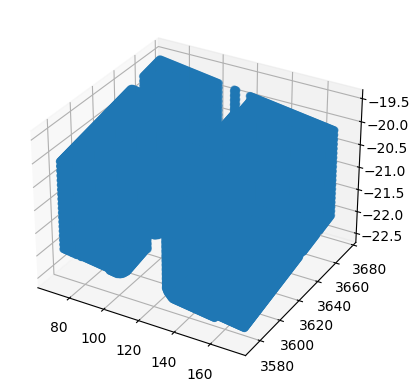

In [108]:
# import sys  
# !{sys.executable} -m pip install --user matplotlib_inline

%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.axes(projection='3d')
jj = points_xy_wrt_city[cmap[:,0]==0]
jmap = cmap[cmap[:,0]!=0]
ax.scatter3D(jj[:,0],
           jj[:,1],
            jj[:,2],
            cmap=jmap
           )

In [75]:
from __future__ import annotations

from typing import Any  # noqa

import numpy as np
import numpy.typing as npt
from av2.geometry.geometry import crop_points

NDArrayNumber = npt.NDArray["np.number[Any]"]
NDArrayBool = npt.NDArray[np.bool_]
NDArrayFloat = npt.NDArray[np.float64]
NDArrayByte = npt.NDArray[np.uint8]
NDArrayInt = npt.NDArray[np.int64]
NDArrayObject = npt.NDArray[np.object_]
NDArrayByte
NDArrayByte = npt.NDArray[np.uint8]

def xyz_to_bev(
    xyz: NDArrayFloat,
    voxel_resolution: Tuple[float, float, float],
    grid_size_m: Tuple[float, float, float],
    cmap: NDArrayFloat,
) -> NDArrayByte:
    """Convert a set of points in Cartesian space to a bird's-eye-view image.
    Args:
        xyz: (N,3) List of points in R^3.
        voxel_resolution: (3,) Number of voxel bins in the (x,y,z) axes.
        grid_size_m: (3,) Size of the grid in the (x,y,z) axes.
        cmap: RGB colormap.
    Returns:
        (H,W,3) RGB image representing a BEV projection onto the xy plane.
    """
    cmap /= 255.0

    # If only xyz are provided, then assume intensity is 1.0.
    # Otherwise, use the provided intensity.
    print(xyz.shape[-1])
    intensity: NDArrayByte
    if xyz.shape[-1] == 3:
        intensity = np.ones(shape=xyz.shape[0], dtype=np.uint8)
    else:
        intensity = xyz[..., -1].copy().astype(np.uint8)
    
    # Grab the Cartesian coordinates (xyz).
    cart = xyz[..., :-1].copy()
    # cart = xyz.copy()

    # Move the origin to the center of the image.
    cart += np.divide(grid_size_m, 2)

    # Scale the Cartesian coordinates by the voxel resolution.
    indices: NDArrayInt = (cart / voxel_resolution).astype(int)

    # Compute the voxel grid size.
    voxel_grid_size_m = (
        int(grid_size_m[0] / voxel_resolution[0]),
        int(grid_size_m[1] / voxel_resolution[1]),
        int(grid_size_m[2] / voxel_resolution[2]),
    )

    # Crop point cloud to the region-of-interest.
    lower_bound_inclusive = (0.0, 0.0, 0.0)
    indices_cropped, grid_boundary_reduction = crop_points(
        indices, lower_bound_inclusive=lower_bound_inclusive, upper_bound_exclusive=grid_size_m
    )
    print(np.count_nonzero(grid_boundary_reduction),grid_boundary_reduction.shape, grid_boundary_reduction)
    print(np.count_nonzero(indices_cropped), indices_cropped.shape, indices_cropped)

    # Filter the indices and intensity values.
    cmap = cmap[grid_boundary_reduction]
    intensity = intensity[grid_boundary_reduction]

    # Create the raster image.
    im_dims = (voxel_grid_size_m[0] + 1, voxel_grid_size_m[1] + 1, cmap.shape[1])
    img: NDArrayByte = np.zeros(im_dims, dtype=np.uint8)

    # Construct uv coordinates.
    uv = indices_cropped[:, :2]

    npoints = len(indices_cropped)
    for i in range(npoints):
        u = uv[i, 0]
        v = uv[i, 1]

        img[u, v, :3] = cmap[i]
        img[u, v, 3:4] += intensity[i]

    # Normalize the intensity.
    img[..., -1] = img[..., -1] / img[..., -1].max()

    # Gamma correction.
    img[..., -1] = np.power(img[..., -1], 0.05)

    # Scale RGB by intensity.
    img[..., :3] *= img[..., -1:]

    # Map RGB in [0, 1] -> [0, 255].
    img[..., :3] = img[..., :3] * 255.0
    im_rgb: NDArrayByte = img[..., :3]
    return im_rgb

In [77]:
output_bev = xyz_to_bev(
    xyz=np.hstack((points_xy_wrt_city, np.ones(points_xy_wrt_city.shape[0])[:, None])),
    voxel_resolution=(1,1,1),
    grid_size_m=(data.bev_info['h_meters'], data.bev_info['w_meters'],1),
    cmap=cmap
)

4
0 (800000,) [False False False ... False False False]
0 (0, 3) []


/tmp/ipykernel_14197/2841141027.py:89: RuntimeWarning: invalid value encountered in divide
  img[..., -1] = img[..., -1] / img[..., -1].max()


In [73]:
output_bev.shape

(1001, 1001, 3)

In [113]:
np.save('/srv/share2/apatni30/tmp/points_src.npy',points_xy_wrt_src)
np.save('/srv/share2/apatni30/tmp/cmap.npy',cmap)